# Demonstrate Use

- get_initial_plan()
- instantiate the recalculator object
- calculate how many minutes of charge are still needed
- after interval passes, get new plan with updated info
- repeat
- return combined schedule


In [14]:
import os
os.chdir("/Users/jen/watttime-python-client")

import watttime.api as wt
import watttime.scratch as scratch
from datetime import timedelta, datetime
from pytz import UTC
import pandas as pd

In [15]:
def get_forecast_dataframe(
          start_time: datetime = datetime(2025, 1, 1, hour=21, second=1, tzinfo=UTC),
          end_time: datetime = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC),
          horizon_hours: int = 12,
          region: str = 'CAISO_NORTH'
        ) -> pd.DataFrame:
        try:
            username = os.getenv("WATTTIME_USER")
            password = os.getenv("WATTTIME_PASSWORD")
            
            if not username or not password:
                raise ValueError("WattTime credentials not found in environment variables")
                
            wth = wt.WattTimeForecast(username=username, password=password)
            
            forecast_dataframe = wth.get_historical_forecast_pandas(
                start=start_time + timedelta(minutes=5),
                end=end_time,
                region=region,
                signal_type="co2_moer",
                horizon_hours=horizon_hours
            )
        except Exception as e:
            raise RuntimeError(f"Error retrieving forecast data: {str(e)}")
        
        return forecast_dataframe

In [16]:
start_time = datetime(2025, 1, 1, hour=21, second=1, tzinfo=UTC)
end_time = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC)
region = 'CAISO_NORTH'

moers = get_forecast_dataframe(start_time=start_time, end_time=end_time, region=region)
requery_dates = moers.generated_at.unique()[0::4] #20 minute intervals

moers_list = []
for d in requery_dates:
    temp = moers[moers.generated_at == d]
    moers_list.append(temp)

In [17]:
import importlib
importlib.reload(wt)

<module 'watttime.api' from '/Users/jen/watttime-python-client/watttime/api.py'>

In [18]:
fitted_recalculator = wt.RequerySimulator(
                                    moers_list,
                                    requery_dates,
                                    region = "CAISO_NORTH",
                                    window_start = start_time,
                                    window_end = end_time,
                                    usage_time_required_minutes = 240,
                                    usage_power_kw = 2
                                    ).simulate()

None
== Simple fit! ==
1
None
== Simple fit! ==
2
None
== Simple fit! ==
3
None
== Simple fit! ==
4
None
== Simple fit! ==
5
None
== Simple fit! ==
6
None
== Simple fit! ==
7
None
== Simple fit! ==
8
None
== Simple fit! ==
9
None
== Simple fit! ==
10
None
== Simple fit! ==
11
None
== Simple fit! ==
12
None
== Simple fit! ==
13
None
== Simple fit! ==
14
None
== Simple fit! ==
15
None
== Simple fit! ==
16
None
== Simple fit! ==
17
None
== Simple fit! ==
18
None
== Simple fit! ==
19
None
== Simple fit! ==
20
None
== Simple fit! ==
21
None
== Simple fit! ==
22
None
== Simple fit! ==
23
None
== Simple fit! ==
24
None
== Simple fit! ==
25
None
== Simple fit! ==
26
None
== Simple fit! ==
27
None
== Simple fit! ==
28
None
== Simple fit! ==
29
None
== Simple fit! ==
30
None
== Simple fit! ==
31
None
== Simple fit! ==
32
None
== Simple fit! ==


<Axes: xlabel='point_time'>

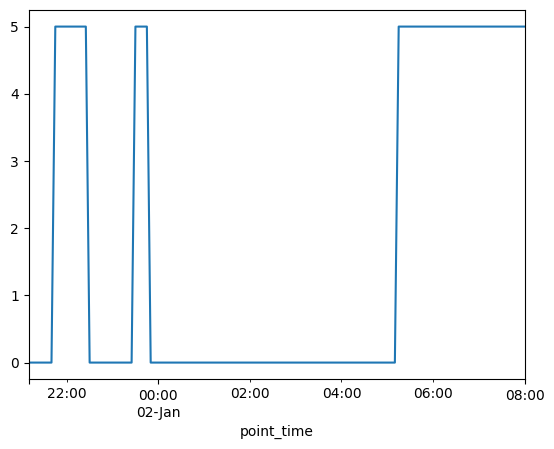

In [28]:
fitted_recalculator.get_combined_schedule()["usage"].plot(kind='line')

In [210]:
from itertools import accumulate
import bisect
from watttime.api import WattTimeOptimizer

import pandas as pd
import matplotlib.pyplot as plt

## Contiguity Test

In [348]:
import importlib
importlib.reload(scratch)

<module 'watttime.scratch' from '/Users/jen/watttime-python-client/watttime/scratch.py'>

In [289]:
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")
region = "SPP_SIOUX"
wt_opt = WattTimeOptimizer(username,password)
#start_time = datetime(2025, 1, 1, hour=21, second=1, tzinfo=UTC)
start_time = requery_dates[11]
end_time = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC)
charge_per_interval=[300, 100]

In [290]:
usage_plan = wt_opt.get_optimal_usage_plan(
            region=region,
            usage_window_start=start_time,
            usage_window_end=end_time,
            usage_time_required_minutes=400,
            usage_power_kw=5,
            charge_per_interval=charge_per_interval,
            optimization_method="auto",
            moer_data_override= moers_list[0]
        )

[60, 20]
== Fixed contiguous fit! ==


<Axes: xlabel='point_time'>

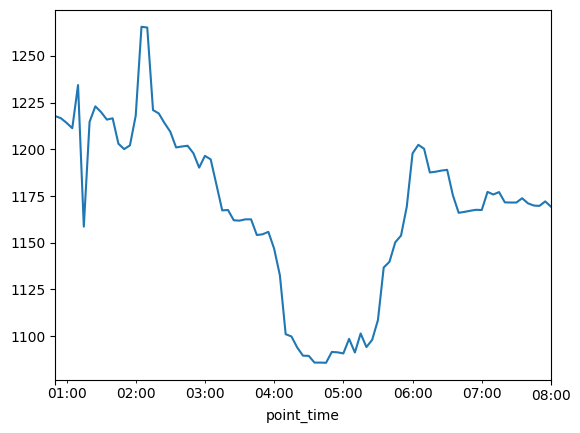

In [291]:
usage_plan.pred_moer.plot(kind='line')

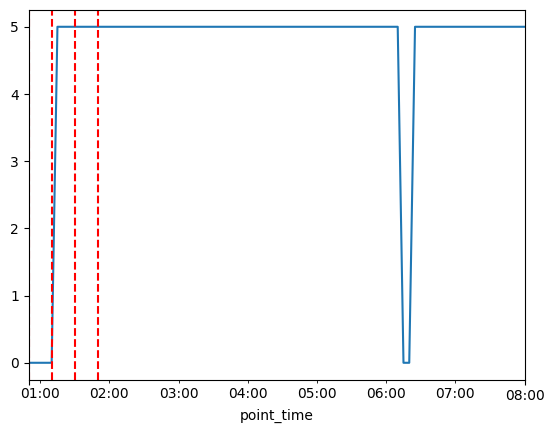

In [292]:
ax = usage_plan.usage.plot()
for d in requery_dates[11:15]:
    plt.axvline(x=d, color='r', linestyle='--')

plt.show()

In [349]:
recalculator = scratch.Recalculator(
    initial_schedule= usage_plan,
    start_time = start_time,
    end_time = end_time,
    total_time_required = 400,
    charge_per_interval=charge_per_interval
)

In [350]:
next_next_start_time = requery_dates[12]
print(recalculator.sleep_delay)
recalculator.update_charging_schedule(next_query_time=start_time, next_new_schedule_start_time=next_next_start_time)
print(recalculator.contiguity_values_dict)

False
{'delay_usage_window_start': None, 'delay_in_minutes': None, 'delay_in_intervals': None, 'remaining_time_required': 400, 'num_segments_complete': 0}


In [351]:
usage_plan_1 = wt_opt.get_optimal_usage_plan(
            region=region,
            usage_window_start=requery_dates[12], #updated
            usage_window_end=end_time,
            usage_time_required_minutes=recalculator.contiguity_values_dict["remaining_time_required"],#updated
            usage_power_kw=5,
            charge_per_interval=charge_per_interval[recalculator.contiguity_values_dict["num_segments_complete"]:], #updated
            optimization_method="auto",
            moer_data_override= moers_list[12]
        )

[60, 20]
== Fixed contiguous fit! ==


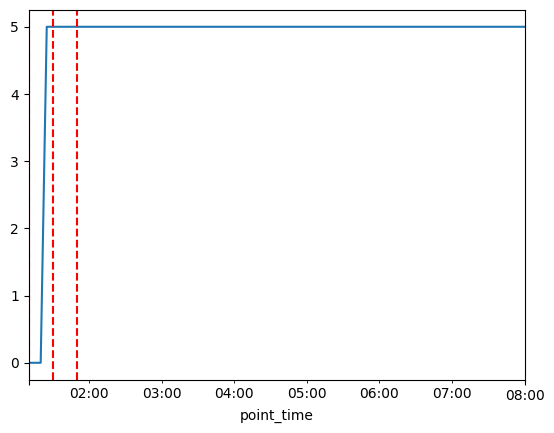

In [352]:
ax = usage_plan_1.usage.plot()
for d in requery_dates[11:15]:
    plt.axvline(x=d, color='r', linestyle='--')

plt.show()

In [353]:
next_next_start_time = requery_dates[13]
recalculator.update_charging_schedule(
    new_schedule = usage_plan_1, 
    next_query_time=requery_dates[12], 
    next_new_schedule_start_time = next_next_start_time
)
print(recalculator.sleep_delay)
print(recalculator.contiguity_values_dict)

True
{'delay_usage_window_start': datetime.datetime(2025, 1, 2, 8, 0, 1, tzinfo=<UTC>), 'delay_in_minutes': 395, 'delay_in_intervals': 79, 'remaining_time_required': 0, 'num_segments_complete': 1}


In [146]:
usage_plan_2 = wt_opt.get_optimal_usage_plan(
            region=region,
            usage_window_start=requery_dates[2], #updated
            usage_window_end=end_time,
            usage_time_required_minutes=recalculator.contiguity_values_dict["remaining_time_required"],#updated
            usage_power_kw=5,
            charge_per_interval=charge_per_interval[recalculator.contiguity_values_dict["num_segments_complete"]:], #updated
            optimization_method="auto",
            moer_data_override= moers_list[2]
        )

[12, 20]
== Fixed contiguous fit! ==


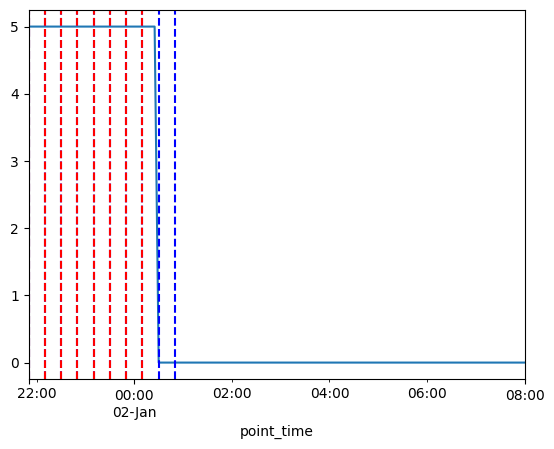

In [147]:
ax = usage_plan_2.usage.plot()
for d in requery_dates[0:12]:
    plt.axvline(x=d, color='b', linestyle='--')

for d in requery_dates[2:10]:
    plt.axvline(x=d, color='r', linestyle='--')

plt.show()

In [148]:
next_usage_plan = usage_plan_2
next_next_start_time = requery_dates[3]
print(recalculator.check_if_contiguity_sleep_required(next_usage_plan, next_next_start_time))
recalculator.update_charging_schedule(
    new_schedule = next_usage_plan, 
    next_query_time=requery_dates[2],
    next_new_schedule_start_time = next_next_start_time
)
print(recalculator.contiguity_values_dict)

True
2025-01-01 21:30:00+00:00
2025-01-01 21:50:00+00:00
{'delay_usage_window_start': Timestamp('2025-01-02 00:30:00+0000', tz='UTC'), 'delay_in_minutes': 140, 'delay_in_intervals': 28, 'remaining_time_required': 0, 'num_segments_complete': 2}


In [238]:
s = recalculator.get_combined_schedule().loc[next_next_start_time:]['usage'] == 0
s[s==False].index.min()

Timestamp('2025-01-02 01:30:00+0000', tz='UTC')